# 简单实现GAN模型

<img src='./image/gan.jpg' />

In [1]:
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
# from google.colab import drive

Using TensorFlow backend.


然后，读取Keras自带的mnist数据集。在这里我们给出一个读取数据的函数load_data()。

In [2]:
# Load the dataset
def load_data():
    (x_train, y_train), (_, _) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # Convert shape from (60000, 28, 28) to (60000, 784)
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train)

X_train, y_train = load_data()
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


由于本文我们旨在实现最原始的GAN网络，因此用最简单MLP全连接层来构建生成器（用卷积层当然更好，在这里先不考虑）

In [3]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(units=256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=1024))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=784, activation='tanh'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model

generator = build_generator()
generator.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
___________________________________________

然后建一个判别器，也是一个MLP全连接神经网络：

In [4]:
def build_discriminator():
    model = Sequential()
    
    model.add(Dense(units=1024 ,input_dim=784))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
       
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
       
    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
      
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model
  
discriminator = build_discriminator()
discriminator.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________________________

然后，我们建立一个GAN网络，由discriminator和generator组成。

In [5]:
def build_GAN(discriminator, generator):
    discriminator.trainable=False
    GAN_input = Input(shape=(100,))
    x = generator(GAN_input)
    GAN_output= discriminator(x)
    GAN = Model(inputs=GAN_input, outputs=GAN_output)
    GAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return GAN

GAN = build_GAN(discriminator, generator)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


然后我们给出绘制图像的函数，用于把generator生成的假图片画出来:

In [6]:
def draw_images(generator, epoch, examples=25, dim=(5,5), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(25,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='Greys')
        plt.axis('off')
    plt.tight_layout()
    folder = r'./output/mnist_gan/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    file_path = os.path.join(folder, 'Generated_images_{0}.png'.format(epoch))
    plt.savefig(file_path)

最后一步，写一个train函数，来训练GAN网络。在这里我们设置最大迭代次数400，每次迭代生成128张假图片。
tqdm用来动态显示每次迭代的进度。

  0%|                                                                                     | 0/128 [00:00<?, ?it/s]

Epoch 1


  4%|███                                                                          | 5/128 [00:00<00:02, 48.09it/s]

Epoch 2


  4%|███                                                                          | 5/128 [00:00<00:02, 45.87it/s]

Epoch 3


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.34it/s]

Epoch 4


  4%|███                                                                          | 5/128 [00:00<00:02, 49.04it/s]

Epoch 5


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 6


  4%|███                                                                          | 5/128 [00:00<00:02, 49.98it/s]

Epoch 7


  4%|███                                                                          | 5/128 [00:00<00:02, 47.62it/s]

Epoch 8


  4%|███                                                                          | 5/128 [00:00<00:02, 48.07it/s]

Epoch 9


  4%|███                                                                          | 5/128 [00:00<00:02, 47.69it/s]

Epoch 10


  4%|███                                                                          | 5/128 [00:00<00:02, 47.62it/s]

Epoch 11


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.55it/s]

Epoch 12


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.44it/s]

Epoch 13


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 14


  4%|███                                                                          | 5/128 [00:00<00:02, 49.50it/s]

Epoch 15


  4%|███                                                                          | 5/128 [00:00<00:02, 48.52it/s]

Epoch 16


  4%|███                                                                          | 5/128 [00:00<00:02, 49.50it/s]

Epoch 17


  4%|███                                                                          | 5/128 [00:00<00:02, 50.00it/s]

Epoch 18


  4%|███                                                                          | 5/128 [00:00<00:02, 48.06it/s]

Epoch 19


  4%|███                                                                          | 5/128 [00:00<00:02, 48.06it/s]

Epoch 20


  4%|███                                                                          | 5/128 [00:00<00:02, 45.87it/s]

Epoch 21


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.17it/s]

Epoch 22


  4%|███                                                                          | 5/128 [00:00<00:02, 48.52it/s]

Epoch 23


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.00it/s]

Epoch 24


  4%|███                                                                          | 5/128 [00:00<00:02, 48.52it/s]

Epoch 25


  4%|███                                                                          | 5/128 [00:00<00:02, 49.98it/s]

Epoch 26


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.15it/s]

Epoch 27


  4%|███                                                                          | 5/128 [00:00<00:02, 49.50it/s]

Epoch 28


  4%|███                                                                          | 5/128 [00:00<00:02, 48.07it/s]

Epoch 29


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 30


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.16it/s]

Epoch 31


  4%|███                                                                          | 5/128 [00:00<00:02, 48.53it/s]

Epoch 32


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.17it/s]

Epoch 33


  5%|███▌                                                                         | 6/128 [00:00<00:02, 49.19it/s]

Epoch 34


  4%|███                                                                          | 5/128 [00:00<00:02, 48.55it/s]

Epoch 35


  4%|███                                                                          | 5/128 [00:00<00:02, 49.02it/s]

Epoch 36


  5%|███▌                                                                         | 6/128 [00:00<00:02, 49.59it/s]

Epoch 37


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.63it/s]

Epoch 38


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.97it/s]

Epoch 39


  4%|███                                                                          | 5/128 [00:00<00:02, 49.50it/s]

Epoch 40


  4%|███                                                                          | 5/128 [00:00<00:02, 49.02it/s]

Epoch 41


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.00it/s]

Epoch 42


  4%|███                                                                          | 5/128 [00:00<00:02, 49.49it/s]

Epoch 43


  4%|███                                                                          | 5/128 [00:00<00:02, 49.51it/s]

Epoch 44


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 45


  4%|███                                                                          | 5/128 [00:00<00:02, 48.52it/s]

Epoch 46


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.50it/s]

Epoch 47


  4%|███                                                                          | 5/128 [00:00<00:02, 44.57it/s]

Epoch 48


  4%|███                                                                          | 5/128 [00:00<00:02, 47.70it/s]

Epoch 49


  4%|███                                                                          | 5/128 [00:00<00:02, 49.02it/s]

Epoch 50


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.00it/s]

Epoch 51


  4%|███                                                                          | 5/128 [00:00<00:02, 49.51it/s]

Epoch 52


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.83it/s]

Epoch 53


  4%|███                                                                          | 5/128 [00:00<00:02, 49.04it/s]

Epoch 54


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.74it/s]

Epoch 55


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 56


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.01it/s]

Epoch 57


  5%|███▌                                                                         | 6/128 [00:00<00:02, 49.98it/s]

Epoch 58


  5%|███▌                                                                         | 6/128 [00:00<00:02, 51.73it/s]

Epoch 59


  4%|███                                                                          | 5/128 [00:00<00:02, 49.98it/s]

Epoch 60


  4%|███                                                                          | 5/128 [00:00<00:02, 49.02it/s]

Epoch 61


  4%|███                                                                          | 5/128 [00:00<00:02, 46.72it/s]

Epoch 62


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.84it/s]

Epoch 63


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.20it/s]

Epoch 64


  5%|███▌                                                                         | 6/128 [00:00<00:02, 51.72it/s]

Epoch 65


  4%|███                                                                          | 5/128 [00:00<00:02, 49.52it/s]

Epoch 66


  4%|███                                                                          | 5/128 [00:00<00:02, 49.98it/s]

Epoch 67


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 68


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.65it/s]

Epoch 69


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.49it/s]

Epoch 70


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.40it/s]

Epoch 71


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.50it/s]

Epoch 72


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.82it/s]

Epoch 73


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.15it/s]

Epoch 74


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.02it/s]

Epoch 75


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.49it/s]

Epoch 76


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.40it/s]

Epoch 77


  4%|███                                                                          | 5/128 [00:00<00:02, 47.17it/s]

Epoch 78


  4%|███                                                                          | 5/128 [00:00<00:02, 49.98it/s]

Epoch 79


  4%|███                                                                          | 5/128 [00:00<00:02, 49.51it/s]

Epoch 80


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.65it/s]

Epoch 81


  4%|███                                                                          | 5/128 [00:00<00:02, 49.48it/s]

Epoch 82


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 83


  4%|███                                                                          | 5/128 [00:00<00:02, 49.48it/s]

Epoch 84


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 85


  4%|███                                                                          | 5/128 [00:00<00:02, 48.06it/s]

Epoch 86


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.02it/s]

Epoch 87


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.01it/s]

Epoch 88


  4%|███                                                                          | 5/128 [00:00<00:02, 43.46it/s]

Epoch 89


  4%|███                                                                          | 5/128 [00:00<00:02, 47.62it/s]

Epoch 90


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.01it/s]

Epoch 91


  4%|███                                                                          | 5/128 [00:00<00:02, 46.74it/s]

Epoch 92


  4%|███                                                                          | 5/128 [00:00<00:02, 48.52it/s]

Epoch 93


  4%|███                                                                          | 5/128 [00:00<00:02, 46.75it/s]

Epoch 94


  4%|███                                                                          | 5/128 [00:00<00:02, 49.98it/s]

Epoch 95


  4%|███                                                                          | 5/128 [00:00<00:02, 48.06it/s]

Epoch 96


  4%|███                                                                          | 5/128 [00:00<00:02, 45.87it/s]

Epoch 97


  4%|███                                                                          | 5/128 [00:00<00:02, 46.30it/s]

Epoch 98


  2%|█▊                                                                           | 3/128 [00:00<00:04, 29.41it/s]

Epoch 99


  4%|███                                                                          | 5/128 [00:00<00:02, 47.16it/s]

Epoch 100


  4%|███                                                                          | 5/128 [00:00<00:02, 46.73it/s]

Epoch 101


  4%|███                                                                          | 5/128 [00:00<00:02, 48.53it/s]

Epoch 102


  4%|███                                                                          | 5/128 [00:00<00:02, 47.18it/s]

Epoch 103


  4%|███                                                                          | 5/128 [00:00<00:02, 48.06it/s]

Epoch 104


  4%|███                                                                          | 5/128 [00:00<00:02, 46.73it/s]

Epoch 105


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.36it/s]

Epoch 106


  4%|███                                                                          | 5/128 [00:00<00:02, 49.98it/s]

Epoch 107


  4%|███                                                                          | 5/128 [00:00<00:02, 49.04it/s]

Epoch 108


  4%|███                                                                          | 5/128 [00:00<00:02, 47.46it/s]

Epoch 109


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 110


  4%|███                                                                          | 5/128 [00:00<00:02, 49.02it/s]

Epoch 111


  4%|███                                                                          | 5/128 [00:00<00:02, 47.15it/s]

Epoch 112


  4%|███                                                                          | 5/128 [00:00<00:02, 46.29it/s]

Epoch 113


  4%|███                                                                          | 5/128 [00:00<00:02, 45.04it/s]

Epoch 114


  4%|███                                                                          | 5/128 [00:00<00:02, 48.54it/s]

Epoch 115


  4%|███                                                                          | 5/128 [00:00<00:02, 49.49it/s]

Epoch 116


  4%|███                                                                          | 5/128 [00:00<00:02, 47.62it/s]

Epoch 117


  4%|███                                                                          | 5/128 [00:00<00:02, 43.86it/s]

Epoch 118


  4%|███                                                                          | 5/128 [00:00<00:02, 48.06it/s]

Epoch 119


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.20it/s]

Epoch 120


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.00it/s]

Epoch 121


  4%|███                                                                          | 5/128 [00:00<00:02, 45.07it/s]

Epoch 122


  4%|███                                                                          | 5/128 [00:00<00:02, 47.60it/s]

Epoch 123


  4%|███                                                                          | 5/128 [00:00<00:02, 46.71it/s]

Epoch 124


  4%|███                                                                          | 5/128 [00:00<00:02, 44.24it/s]

Epoch 125


  4%|███                                                                          | 5/128 [00:00<00:02, 47.17it/s]

Epoch 126


  4%|███                                                                          | 5/128 [00:00<00:02, 48.53it/s]

Epoch 127


  4%|███                                                                          | 5/128 [00:00<00:02, 47.62it/s]

Epoch 128


  4%|███                                                                          | 5/128 [00:00<00:02, 48.54it/s]

Epoch 129


  4%|███                                                                          | 5/128 [00:00<00:02, 45.05it/s]

Epoch 130


  4%|███                                                                          | 5/128 [00:00<00:02, 48.56it/s]

Epoch 131


  4%|███                                                                          | 5/128 [00:00<00:02, 45.05it/s]

Epoch 132


  4%|███                                                                          | 5/128 [00:00<00:02, 49.51it/s]

Epoch 133


  3%|██▍                                                                          | 4/128 [00:00<00:03, 39.61it/s]

Epoch 134


  4%|███                                                                          | 5/128 [00:00<00:02, 45.87it/s]

Epoch 135


  4%|███                                                                          | 5/128 [00:00<00:02, 47.17it/s]

Epoch 136


  4%|███                                                                          | 5/128 [00:00<00:02, 45.39it/s]

Epoch 137


  4%|███                                                                          | 5/128 [00:00<00:02, 45.04it/s]

Epoch 138


  4%|███                                                                          | 5/128 [00:00<00:02, 45.05it/s]

Epoch 139


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.68it/s]

Epoch 140


  4%|███                                                                          | 5/128 [00:00<00:02, 48.54it/s]

Epoch 141


  4%|███                                                                          | 5/128 [00:00<00:02, 48.55it/s]

Epoch 142


  4%|███                                                                          | 5/128 [00:00<00:02, 45.85it/s]

Epoch 143


  4%|███                                                                          | 5/128 [00:00<00:02, 43.12it/s]

Epoch 144


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.42it/s]

Epoch 145


  4%|███                                                                          | 5/128 [00:00<00:02, 45.44it/s]

Epoch 146


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.86it/s]

Epoch 147


  4%|███                                                                          | 5/128 [00:00<00:02, 49.51it/s]

Epoch 148


  4%|███                                                                          | 5/128 [00:00<00:02, 47.62it/s]

Epoch 149


  4%|███                                                                          | 5/128 [00:00<00:02, 49.02it/s]

Epoch 150


  4%|███                                                                          | 5/128 [00:00<00:02, 49.01it/s]

Epoch 151


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.00it/s]

Epoch 152


  5%|███▌                                                                         | 6/128 [00:00<00:02, 49.99it/s]

Epoch 153


  4%|███                                                                          | 5/128 [00:00<00:02, 46.29it/s]

Epoch 154


  4%|███                                                                          | 5/128 [00:00<00:02, 44.26it/s]

Epoch 155


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.85it/s]

Epoch 156


  4%|███                                                                          | 5/128 [00:00<00:02, 44.25it/s]

Epoch 157


  4%|███                                                                          | 5/128 [00:00<00:02, 49.02it/s]

Epoch 158


  4%|███                                                                          | 5/128 [00:00<00:02, 41.31it/s]

Epoch 159


  4%|███                                                                          | 5/128 [00:00<00:02, 45.89it/s]

Epoch 160


  4%|███                                                                          | 5/128 [00:00<00:02, 47.18it/s]

Epoch 161


  4%|███                                                                          | 5/128 [00:00<00:02, 45.44it/s]

Epoch 162


  4%|███                                                                          | 5/128 [00:00<00:02, 45.05it/s]

Epoch 163


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.32it/s]

Epoch 164


  4%|███                                                                          | 5/128 [00:00<00:02, 49.48it/s]

Epoch 165


  4%|███                                                                          | 5/128 [00:00<00:02, 47.15it/s]

Epoch 166


  4%|███                                                                          | 5/128 [00:00<00:02, 45.45it/s]

Epoch 167


  4%|███                                                                          | 5/128 [00:00<00:02, 44.63it/s]

Epoch 168


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.35it/s]

Epoch 169


  5%|███▌                                                                         | 6/128 [00:00<00:02, 49.59it/s]

Epoch 170


  4%|███                                                                          | 5/128 [00:00<00:02, 44.13it/s]

Epoch 171


  4%|███                                                                          | 5/128 [00:00<00:02, 43.48it/s]

Epoch 172


  4%|███                                                                          | 5/128 [00:00<00:02, 47.62it/s]

Epoch 173


  4%|███                                                                          | 5/128 [00:00<00:02, 46.73it/s]

Epoch 174


  4%|███                                                                          | 5/128 [00:00<00:02, 45.03it/s]

Epoch 175


  4%|███                                                                          | 5/128 [00:00<00:02, 46.30it/s]

Epoch 176


  4%|███                                                                          | 5/128 [00:00<00:02, 45.45it/s]

Epoch 177


  4%|███                                                                          | 5/128 [00:00<00:03, 40.98it/s]

Epoch 178


  4%|███                                                                          | 5/128 [00:00<00:02, 45.87it/s]

Epoch 179


  4%|███                                                                          | 5/128 [00:00<00:02, 46.28it/s]

Epoch 180


  4%|███                                                                          | 5/128 [00:00<00:02, 46.73it/s]

Epoch 181


  4%|███                                                                          | 5/128 [00:00<00:02, 45.45it/s]

Epoch 182


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.20it/s]

Epoch 183


  4%|███                                                                          | 5/128 [00:00<00:02, 42.02it/s]

Epoch 184


  4%|███                                                                          | 5/128 [00:00<00:02, 48.53it/s]

Epoch 185


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.00it/s]

Epoch 186


  4%|███                                                                          | 5/128 [00:00<00:02, 50.00it/s]

Epoch 187


  4%|███                                                                          | 5/128 [00:00<00:02, 49.98it/s]

Epoch 188


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.39it/s]

Epoch 189


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.87it/s]

Epoch 190


  4%|███                                                                          | 5/128 [00:00<00:02, 49.02it/s]

Epoch 191


  4%|███                                                                          | 5/128 [00:00<00:02, 49.32it/s]

Epoch 192


  4%|███                                                                          | 5/128 [00:00<00:02, 44.63it/s]

Epoch 193


  4%|███                                                                          | 5/128 [00:00<00:02, 43.85it/s]

Epoch 194


  4%|███                                                                          | 5/128 [00:00<00:02, 45.86it/s]

Epoch 195


  4%|███                                                                          | 5/128 [00:00<00:02, 47.19it/s]

Epoch 196


  4%|███                                                                          | 5/128 [00:00<00:02, 44.63it/s]

Epoch 197


  4%|███                                                                          | 5/128 [00:00<00:02, 45.44it/s]

Epoch 198


  4%|███                                                                          | 5/128 [00:00<00:03, 40.60it/s]

Epoch 199


  4%|███                                                                          | 5/128 [00:00<00:02, 46.28it/s]

Epoch 200


100%|███████████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 45.13it/s]
c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
  4%|███                                                                          | 5/128 [00:00<00:02, 47.17it/s]

Epoch 201


  4%|███                                                                          | 5/128 [00:00<00:02, 43.09it/s]

Epoch 202


  4%|███                                                                          | 5/128 [00:00<00:02, 44.64it/s]

Epoch 203


  4%|███                                                                          | 5/128 [00:00<00:02, 45.87it/s]

Epoch 204


  4%|███                                                                          | 5/128 [00:00<00:02, 49.51it/s]

Epoch 205


  4%|███                                                                          | 5/128 [00:00<00:02, 43.48it/s]

Epoch 206


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 207


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.83it/s]

Epoch 208


  4%|███                                                                          | 5/128 [00:00<00:02, 45.04it/s]

Epoch 209


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.40it/s]

Epoch 210


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.14it/s]

Epoch 211


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.42it/s]

Epoch 212


  4%|███                                                                          | 5/128 [00:00<00:02, 49.50it/s]

Epoch 213


  4%|███                                                                          | 5/128 [00:00<00:02, 48.33it/s]

Epoch 214


  4%|███                                                                          | 5/128 [00:00<00:02, 41.82it/s]

Epoch 215


  4%|███                                                                          | 5/128 [00:00<00:02, 44.26it/s]

Epoch 216


  4%|███                                                                          | 5/128 [00:00<00:02, 45.45it/s]

Epoch 217


  4%|███                                                                          | 5/128 [00:00<00:02, 42.43it/s]

Epoch 218


  4%|███                                                                          | 5/128 [00:00<00:02, 44.13it/s]

Epoch 219


  4%|███                                                                          | 5/128 [00:00<00:02, 47.79it/s]

Epoch 220


  4%|███                                                                          | 5/128 [00:00<00:02, 45.86it/s]

Epoch 221


  4%|███                                                                          | 5/128 [00:00<00:02, 45.85it/s]

Epoch 222


  4%|███                                                                          | 5/128 [00:00<00:02, 48.08it/s]

Epoch 223


  4%|███                                                                          | 5/128 [00:00<00:02, 45.45it/s]

Epoch 224


  4%|███                                                                          | 5/128 [00:00<00:02, 45.80it/s]

Epoch 225


  4%|███                                                                          | 5/128 [00:00<00:02, 44.63it/s]

Epoch 226


  4%|███                                                                          | 5/128 [00:00<00:02, 49.98it/s]

Epoch 227


  4%|███                                                                          | 5/128 [00:00<00:02, 49.99it/s]

Epoch 228


  4%|███                                                                          | 5/128 [00:00<00:02, 46.29it/s]

Epoch 229


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.40it/s]

Epoch 230


  4%|███                                                                          | 5/128 [00:00<00:02, 47.17it/s]

Epoch 231


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.51it/s]

Epoch 232


  4%|███                                                                          | 5/128 [00:00<00:02, 47.61it/s]

Epoch 233


  4%|███                                                                          | 5/128 [00:00<00:02, 41.31it/s]

Epoch 234


  3%|██▍                                                                          | 4/128 [00:00<00:03, 33.75it/s]

Epoch 235


  4%|███                                                                          | 5/128 [00:00<00:02, 42.03it/s]

Epoch 236


  4%|███                                                                          | 5/128 [00:00<00:02, 43.88it/s]

Epoch 237


  4%|███                                                                          | 5/128 [00:00<00:02, 44.66it/s]

Epoch 238


  4%|███                                                                          | 5/128 [00:00<00:02, 44.52it/s]

Epoch 239


  4%|███                                                                          | 5/128 [00:00<00:02, 43.48it/s]

Epoch 240


  4%|███                                                                          | 5/128 [00:00<00:02, 44.25it/s]

Epoch 241


  4%|███                                                                          | 5/128 [00:00<00:02, 44.64it/s]

Epoch 242


  4%|███                                                                          | 5/128 [00:00<00:02, 45.04it/s]

Epoch 243


  4%|███                                                                          | 5/128 [00:00<00:02, 43.87it/s]

Epoch 244


  4%|███                                                                          | 5/128 [00:00<00:02, 42.00it/s]

Epoch 245


  4%|███                                                                          | 5/128 [00:00<00:02, 47.62it/s]

Epoch 246


  4%|███                                                                          | 5/128 [00:00<00:02, 49.04it/s]

Epoch 247


  4%|███                                                                          | 5/128 [00:00<00:03, 40.65it/s]

Epoch 248


  4%|███                                                                          | 5/128 [00:00<00:02, 41.10it/s]

Epoch 249


  4%|███                                                                          | 5/128 [00:00<00:02, 46.30it/s]

Epoch 250


  4%|███                                                                          | 5/128 [00:00<00:02, 47.16it/s]

Epoch 251


  4%|███                                                                          | 5/128 [00:00<00:02, 43.47it/s]

Epoch 252


  4%|███                                                                          | 5/128 [00:00<00:02, 42.36it/s]

Epoch 253


  4%|███                                                                          | 5/128 [00:00<00:02, 45.47it/s]

Epoch 254


  4%|███                                                                          | 5/128 [00:00<00:02, 45.46it/s]

Epoch 255


  4%|███                                                                          | 5/128 [00:00<00:02, 46.30it/s]

Epoch 256


  4%|███                                                                          | 5/128 [00:00<00:02, 49.00it/s]

Epoch 257


  4%|███                                                                          | 5/128 [00:00<00:02, 49.98it/s]

Epoch 258


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.85it/s]

Epoch 259


  5%|███▌                                                                         | 6/128 [00:00<00:02, 49.59it/s]

Epoch 260


  4%|███                                                                          | 5/128 [00:00<00:02, 46.28it/s]

Epoch 261


  4%|███                                                                          | 5/128 [00:00<00:02, 45.45it/s]

Epoch 262


  4%|███                                                                          | 5/128 [00:00<00:02, 45.74it/s]

Epoch 263


  4%|███                                                                          | 5/128 [00:00<00:02, 47.63it/s]

Epoch 264


  4%|███                                                                          | 5/128 [00:00<00:02, 45.06it/s]

Epoch 265


  4%|███                                                                          | 5/128 [00:00<00:02, 45.47it/s]

Epoch 266


  4%|███                                                                          | 5/128 [00:00<00:02, 45.88it/s]

Epoch 267


  4%|███                                                                          | 5/128 [00:00<00:02, 45.05it/s]

Epoch 268


  4%|███                                                                          | 5/128 [00:00<00:02, 45.80it/s]

Epoch 269


  4%|███                                                                          | 5/128 [00:00<00:02, 43.86it/s]

Epoch 270


  4%|███                                                                          | 5/128 [00:00<00:02, 45.85it/s]

Epoch 271


  4%|███                                                                          | 5/128 [00:00<00:02, 44.64it/s]

Epoch 272


  4%|███                                                                          | 5/128 [00:00<00:02, 44.24it/s]

Epoch 273


  4%|███                                                                          | 5/128 [00:00<00:02, 44.64it/s]

Epoch 274


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 47.76it/s]

Epoch 275


  4%|███                                                                          | 5/128 [00:00<00:02, 46.73it/s]

Epoch 276


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.41it/s]

Epoch 277


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.48it/s]

Epoch 278


  4%|███                                                                          | 5/128 [00:00<00:02, 45.85it/s]

Epoch 279


  4%|███                                                                          | 5/128 [00:00<00:02, 48.00it/s]

Epoch 280


  4%|███                                                                          | 5/128 [00:00<00:02, 47.17it/s]

Epoch 281


  4%|███                                                                          | 5/128 [00:00<00:02, 46.29it/s]

Epoch 282


  4%|███                                                                          | 5/128 [00:00<00:02, 43.86it/s]

Epoch 283


  4%|███                                                                          | 5/128 [00:00<00:02, 46.29it/s]

Epoch 284


  4%|███                                                                          | 5/128 [00:00<00:02, 45.99it/s]

Epoch 285


  4%|███                                                                          | 5/128 [00:00<00:02, 45.47it/s]

Epoch 286


  4%|███                                                                          | 5/128 [00:00<00:02, 44.25it/s]

Epoch 287


  4%|███                                                                          | 5/128 [00:00<00:02, 45.87it/s]

Epoch 288


  4%|███                                                                          | 5/128 [00:00<00:02, 45.85it/s]

Epoch 289


  4%|███                                                                          | 5/128 [00:00<00:02, 42.03it/s]

Epoch 290


  4%|███                                                                          | 5/128 [00:00<00:02, 48.06it/s]

Epoch 291


  4%|███                                                                          | 5/128 [00:00<00:02, 41.32it/s]

Epoch 292


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.85it/s]

Epoch 293


  4%|███                                                                          | 5/128 [00:00<00:02, 44.23it/s]

Epoch 294


  4%|███                                                                          | 5/128 [00:00<00:02, 42.37it/s]

Epoch 295


  3%|██▍                                                                          | 4/128 [00:00<00:03, 37.72it/s]

Epoch 296


  4%|███                                                                          | 5/128 [00:00<00:02, 46.28it/s]

Epoch 297


  4%|███                                                                          | 5/128 [00:00<00:02, 47.64it/s]

Epoch 298


  4%|███                                                                          | 5/128 [00:00<00:02, 48.55it/s]

Epoch 299


  4%|███                                                                          | 5/128 [00:00<00:02, 48.53it/s]

Epoch 300


  4%|███                                                                          | 5/128 [00:00<00:02, 46.73it/s]

Epoch 301


  4%|███                                                                          | 5/128 [00:00<00:02, 44.25it/s]

Epoch 302


  4%|███                                                                          | 5/128 [00:00<00:02, 44.25it/s]

Epoch 303


  4%|███                                                                          | 5/128 [00:00<00:02, 43.86it/s]

Epoch 304


  4%|███                                                                          | 5/128 [00:00<00:02, 43.84it/s]

Epoch 305


  4%|███                                                                          | 5/128 [00:00<00:02, 42.73it/s]

Epoch 306


  4%|███                                                                          | 5/128 [00:00<00:02, 42.74it/s]

Epoch 307


  4%|███                                                                          | 5/128 [00:00<00:03, 40.98it/s]

Epoch 308


  4%|███                                                                          | 5/128 [00:00<00:02, 44.25it/s]

Epoch 309


  4%|███                                                                          | 5/128 [00:00<00:02, 42.72it/s]

Epoch 310


  4%|███                                                                          | 5/128 [00:00<00:02, 43.88it/s]

Epoch 311


  4%|███                                                                          | 5/128 [00:00<00:02, 44.63it/s]

Epoch 312


  4%|███                                                                          | 5/128 [00:00<00:02, 42.74it/s]

Epoch 313


  4%|███                                                                          | 5/128 [00:00<00:02, 43.48it/s]

Epoch 314


  4%|███                                                                          | 5/128 [00:00<00:02, 44.25it/s]

Epoch 315


  4%|███                                                                          | 5/128 [00:00<00:02, 43.48it/s]

Epoch 316


  4%|███                                                                          | 5/128 [00:00<00:02, 43.48it/s]

Epoch 317


  4%|███                                                                          | 5/128 [00:00<00:02, 44.25it/s]

Epoch 318


  4%|███                                                                          | 5/128 [00:00<00:03, 40.65it/s]

Epoch 319


  4%|███                                                                          | 5/128 [00:00<00:02, 48.55it/s]

Epoch 320


  4%|███                                                                          | 5/128 [00:00<00:02, 47.73it/s]

Epoch 321


  4%|███                                                                          | 5/128 [00:00<00:02, 45.87it/s]

Epoch 322


  4%|███                                                                          | 5/128 [00:00<00:02, 48.08it/s]

Epoch 323


  4%|███                                                                          | 5/128 [00:00<00:02, 43.47it/s]

Epoch 324


  4%|███                                                                          | 5/128 [00:00<00:02, 43.10it/s]

Epoch 325


  4%|███                                                                          | 5/128 [00:00<00:02, 45.03it/s]

Epoch 326


  4%|███                                                                          | 5/128 [00:00<00:02, 44.49it/s]

Epoch 327


  4%|███                                                                          | 5/128 [00:00<00:02, 45.04it/s]

Epoch 328


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.54it/s]

Epoch 329


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 48.88it/s]

Epoch 330


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.07it/s]

Epoch 331


  4%|███                                                                          | 5/128 [00:00<00:02, 48.54it/s]

Epoch 332


  5%|███▌                                                                         | 6/128 [00:00<00:02, 49.92it/s]

Epoch 333


  5%|███▌                                                                         | 6/128 [00:00<00:02, 50.85it/s]

Epoch 334


  8%|█████▉                                                                      | 10/128 [00:00<00:02, 49.70it/s]

Epoch 335


  5%|███▌                                                                         | 6/128 [00:00<00:02, 49.98it/s]

Epoch 336


  4%|███                                                                          | 5/128 [00:00<00:02, 46.28it/s]

Epoch 337


  4%|███                                                                          | 5/128 [00:00<00:02, 44.25it/s]

Epoch 338


  4%|███                                                                          | 5/128 [00:00<00:02, 45.03it/s]

Epoch 339


  4%|███                                                                          | 5/128 [00:00<00:02, 45.46it/s]

Epoch 340


  4%|███                                                                          | 5/128 [00:00<00:02, 41.67it/s]

Epoch 341


  3%|██▍                                                                          | 4/128 [00:00<00:03, 39.20it/s]

Epoch 342


  2%|█▊                                                                           | 3/128 [00:00<00:05, 24.57it/s]

Epoch 343


  3%|██▍                                                                          | 4/128 [00:00<00:03, 33.62it/s]

Epoch 344


  3%|██▍                                                                          | 4/128 [00:00<00:03, 39.61it/s]

Epoch 345


  1%|▌                                                                            | 1/128 [00:00<00:14,  9.01it/s]

Epoch 346


  2%|█▏                                                                           | 2/128 [00:00<00:06, 19.07it/s]

Epoch 347


  0%|                                                                                     | 0/128 [00:00<?, ?it/s]

Epoch 348


  2%|█▊                                                                           | 3/128 [00:00<00:05, 21.76it/s]

Epoch 349


  3%|██▍                                                                          | 4/128 [00:00<00:04, 29.83it/s]

Epoch 350


  4%|███                                                                          | 5/128 [00:00<00:02, 43.11it/s]

Epoch 351


  4%|███                                                                          | 5/128 [00:00<00:02, 43.48it/s]

Epoch 352


  2%|█▊                                                                           | 3/128 [00:00<00:04, 30.00it/s]

Epoch 353


  4%|███                                                                          | 5/128 [00:00<00:02, 41.67it/s]

Epoch 354


  2%|█▊                                                                           | 3/128 [00:00<00:04, 29.13it/s]

Epoch 355


  3%|██▍                                                                          | 4/128 [00:00<00:03, 35.40it/s]

Epoch 356


  4%|███                                                                          | 5/128 [00:00<00:02, 42.74it/s]

Epoch 357


  4%|███                                                                          | 5/128 [00:00<00:02, 45.45it/s]

Epoch 358


  4%|███                                                                          | 5/128 [00:00<00:02, 46.28it/s]

Epoch 359


  4%|███                                                                          | 5/128 [00:00<00:02, 42.39it/s]

Epoch 360


  4%|███                                                                          | 5/128 [00:00<00:02, 46.30it/s]

Epoch 361


  4%|███                                                                          | 5/128 [00:00<00:03, 40.65it/s]

Epoch 362


  4%|███                                                                          | 5/128 [00:00<00:02, 41.31it/s]

Epoch 363


  4%|███                                                                          | 5/128 [00:00<00:03, 40.63it/s]

Epoch 364


  3%|██▍                                                                          | 4/128 [00:00<00:03, 38.10it/s]

Epoch 365


  3%|██▍                                                                          | 4/128 [00:00<00:03, 34.78it/s]

Epoch 366


  4%|███                                                                          | 5/128 [00:00<00:02, 41.67it/s]

Epoch 367


  6%|████▊                                                                        | 8/128 [00:00<00:03, 39.60it/s]

Epoch 368


  4%|███                                                                          | 5/128 [00:00<00:02, 41.32it/s]

Epoch 369


  4%|███                                                                          | 5/128 [00:00<00:02, 44.64it/s]

Epoch 370


  4%|███                                                                          | 5/128 [00:00<00:02, 44.25it/s]

Epoch 371


  4%|███                                                                          | 5/128 [00:00<00:02, 48.06it/s]

Epoch 372


  4%|███                                                                          | 5/128 [00:00<00:02, 43.47it/s]

Epoch 373


  4%|███                                                                          | 5/128 [00:00<00:02, 43.11it/s]

Epoch 374


  4%|███                                                                          | 5/128 [00:00<00:02, 41.92it/s]

Epoch 375


  4%|███                                                                          | 5/128 [00:00<00:02, 43.86it/s]

Epoch 376


  4%|███                                                                          | 5/128 [00:00<00:02, 46.28it/s]

Epoch 377


  4%|███                                                                          | 5/128 [00:00<00:02, 45.46it/s]

Epoch 378


  4%|███                                                                          | 5/128 [00:00<00:02, 42.37it/s]

Epoch 379


  4%|███                                                                          | 5/128 [00:00<00:02, 48.08it/s]

Epoch 380


  4%|███                                                                          | 5/128 [00:00<00:02, 45.87it/s]

Epoch 381


  4%|███                                                                          | 5/128 [00:00<00:02, 49.50it/s]

Epoch 382


  3%|██▍                                                                          | 4/128 [00:00<00:03, 36.70it/s]

Epoch 383


  3%|██▍                                                                          | 4/128 [00:00<00:03, 35.40it/s]

Epoch 384


  2%|█▊                                                                           | 3/128 [00:00<00:04, 27.52it/s]

Epoch 385


  2%|█▊                                                                           | 3/128 [00:00<00:04, 27.03it/s]

Epoch 386


  4%|███                                                                          | 5/128 [00:00<00:02, 41.65it/s]

Epoch 387


  4%|███                                                                          | 5/128 [00:00<00:02, 42.72it/s]

Epoch 388


  4%|███                                                                          | 5/128 [00:00<00:02, 42.01it/s]

Epoch 389


  4%|███                                                                          | 5/128 [00:00<00:02, 41.67it/s]

Epoch 390


  4%|███                                                                          | 5/128 [00:00<00:02, 42.36it/s]

Epoch 391


  3%|██▍                                                                          | 4/128 [00:00<00:03, 39.61it/s]

Epoch 392


  4%|███                                                                          | 5/128 [00:00<00:02, 45.04it/s]

Epoch 393


  4%|███                                                                          | 5/128 [00:00<00:02, 45.87it/s]

Epoch 394


  4%|███                                                                          | 5/128 [00:00<00:02, 43.86it/s]

Epoch 395


  4%|███                                                                          | 5/128 [00:00<00:02, 47.48it/s]

Epoch 396


  3%|██▍                                                                          | 4/128 [00:00<00:03, 35.09it/s]

Epoch 397


  3%|██▍                                                                          | 4/128 [00:00<00:03, 36.01it/s]

Epoch 398


  4%|███                                                                          | 5/128 [00:00<00:02, 41.65it/s]

Epoch 399


  3%|██▍                                                                          | 4/128 [00:00<00:03, 38.84it/s]

Epoch 400


100%|███████████████████████████████████████████████████████████████████████████| 128/128 [00:03<00:00, 40.65it/s]


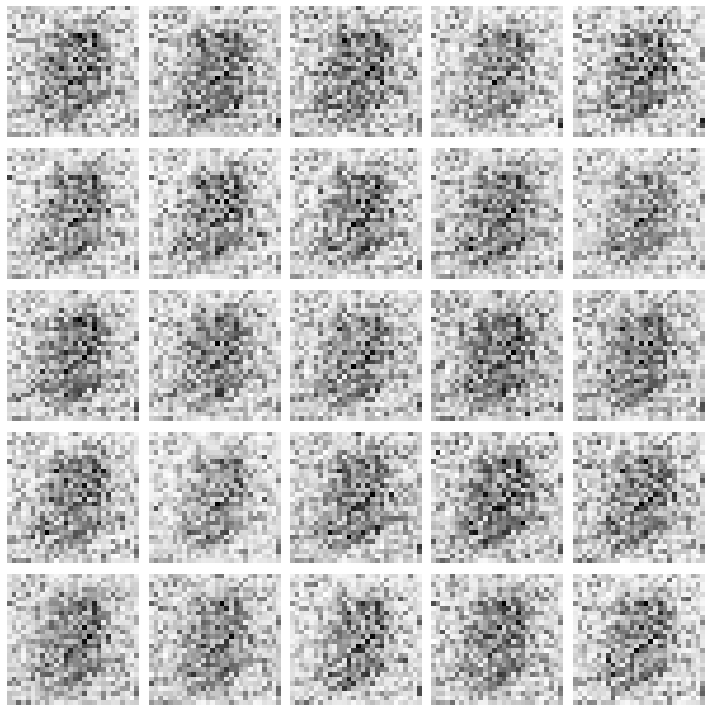

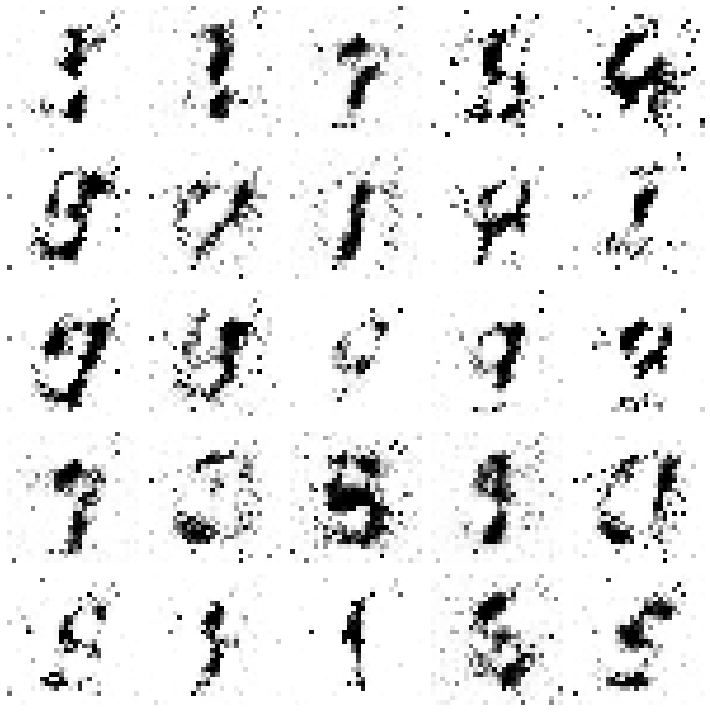

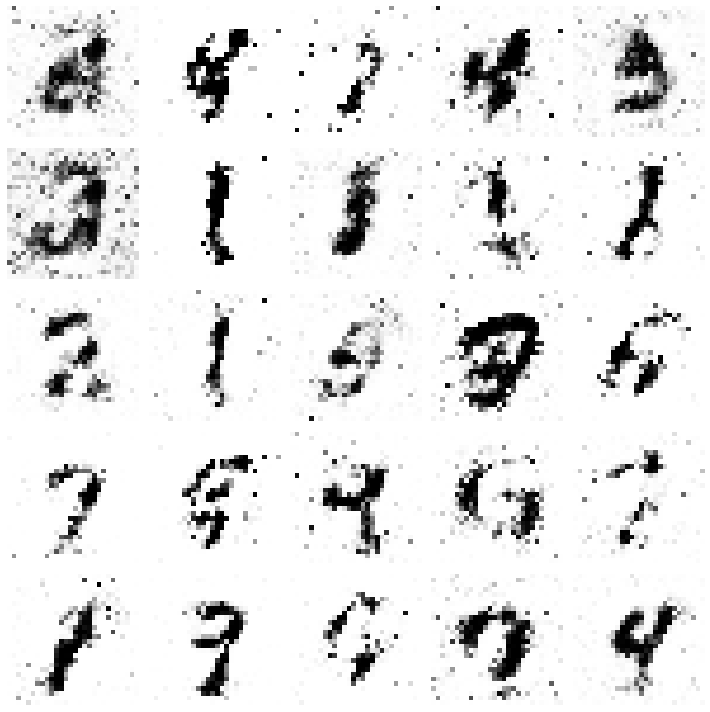

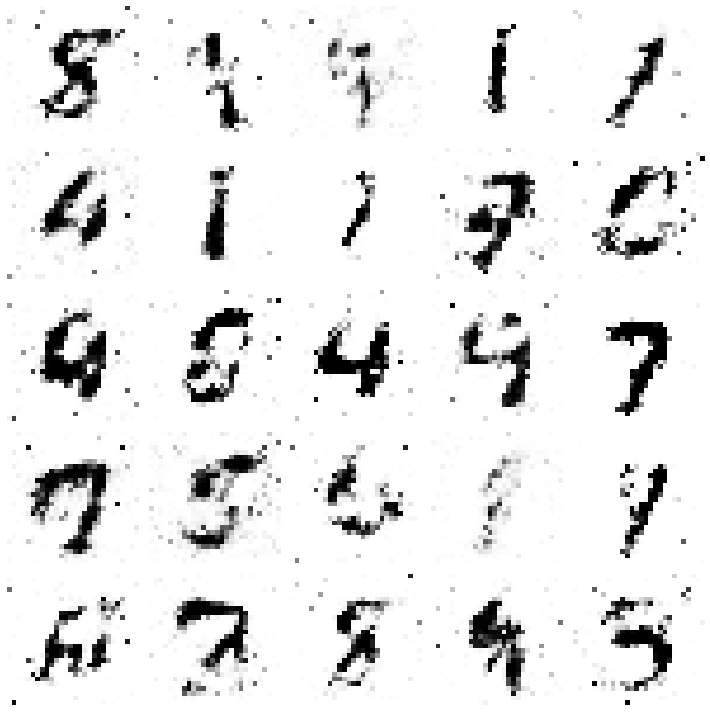

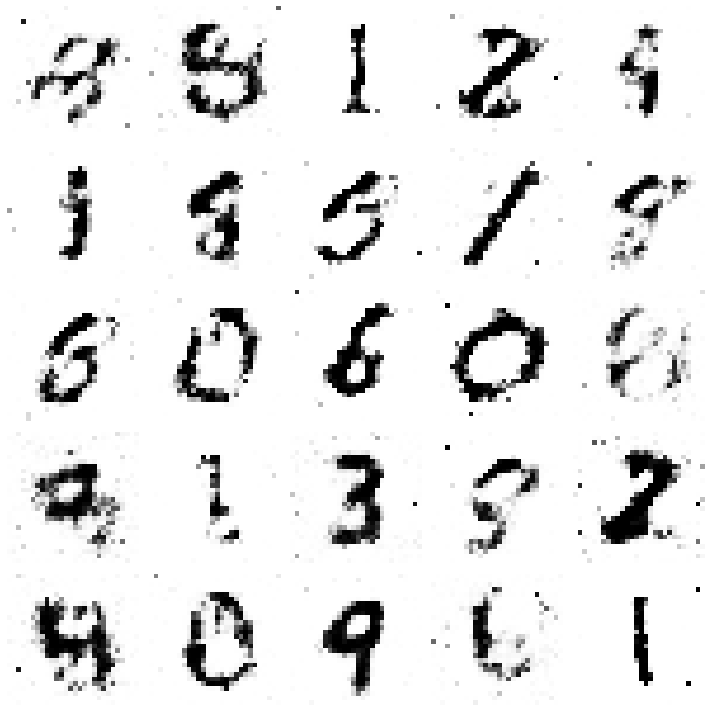

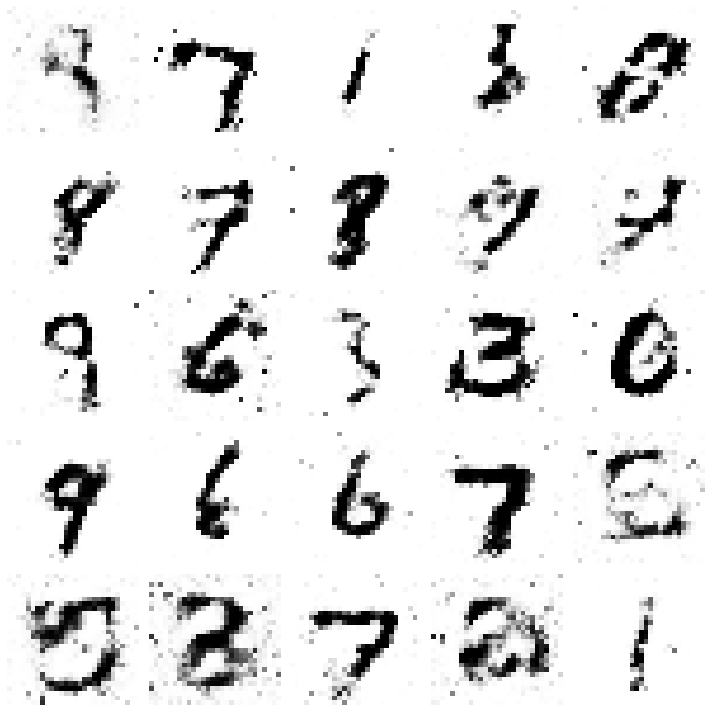

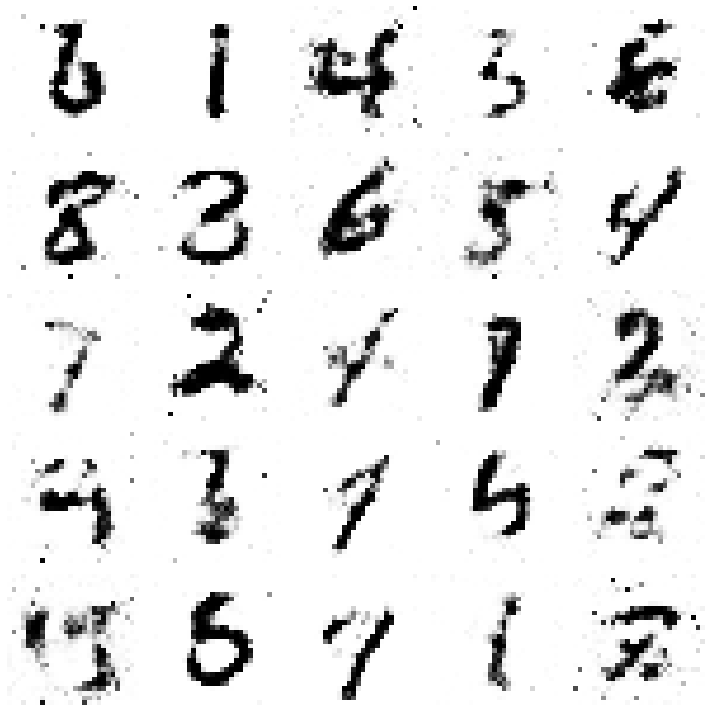

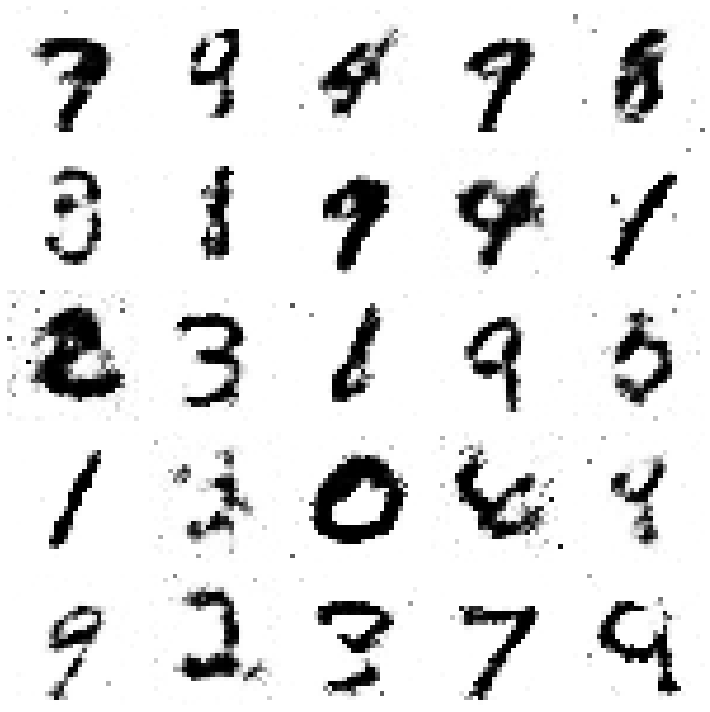

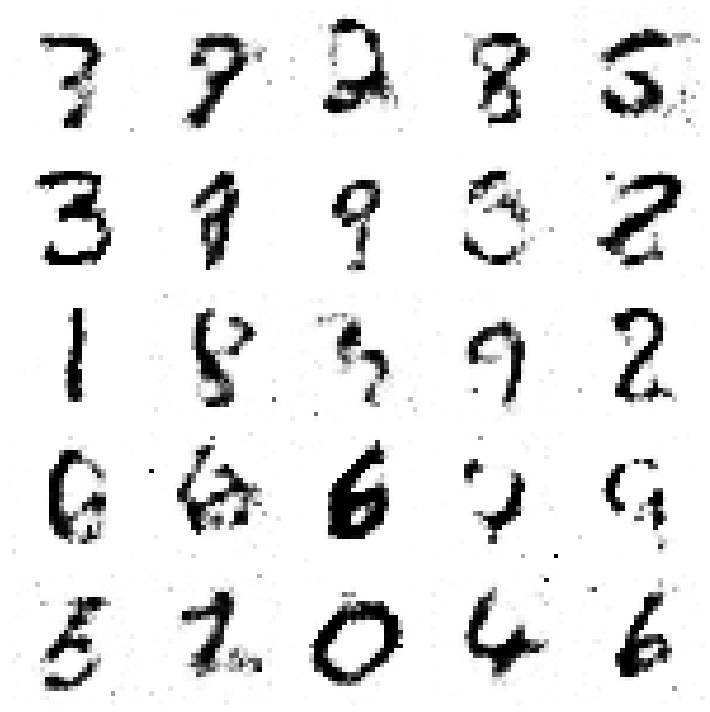

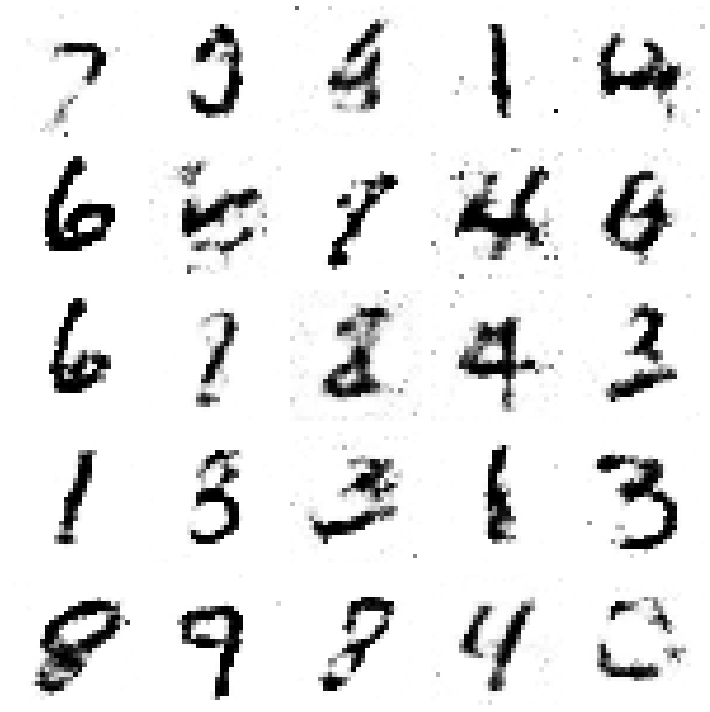

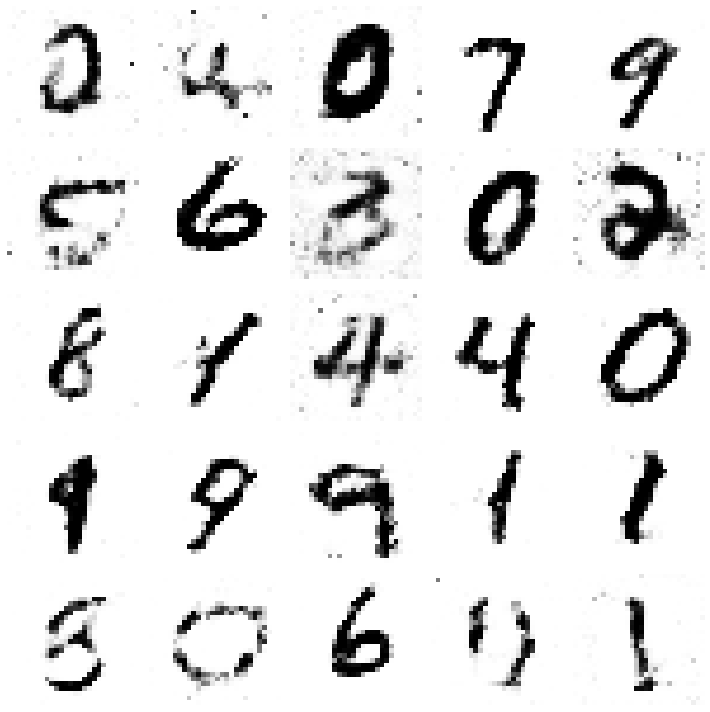

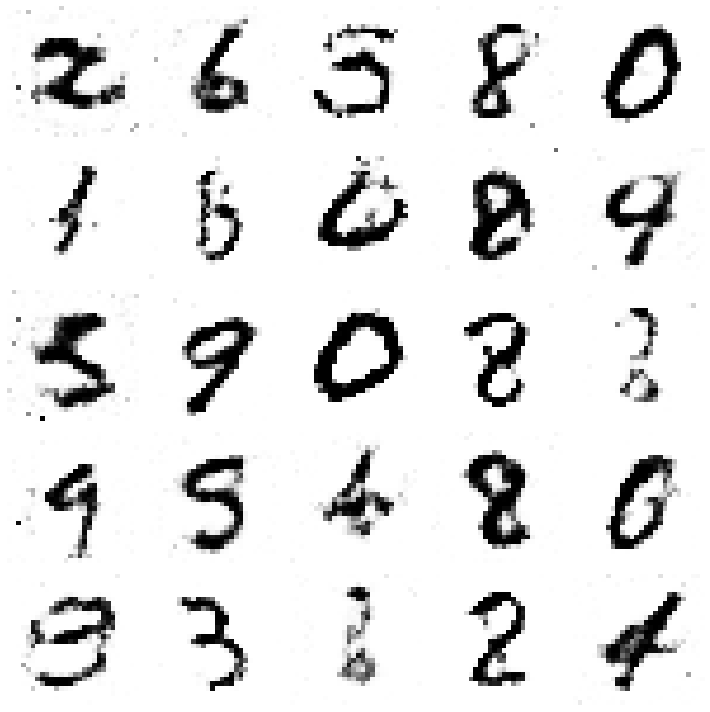

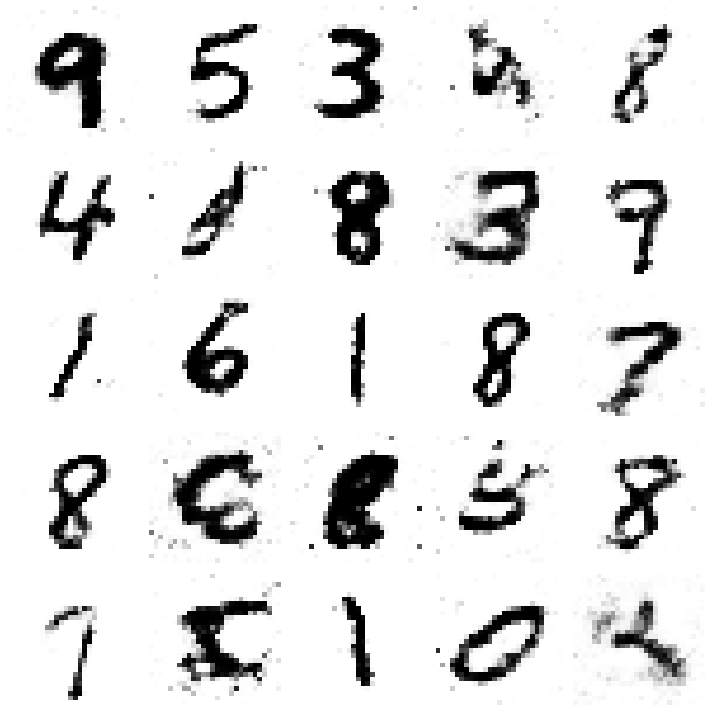

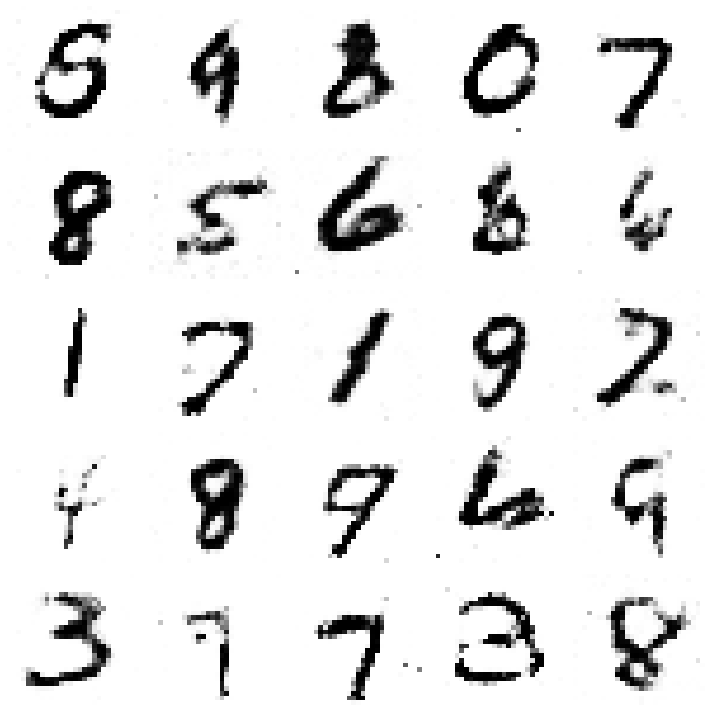

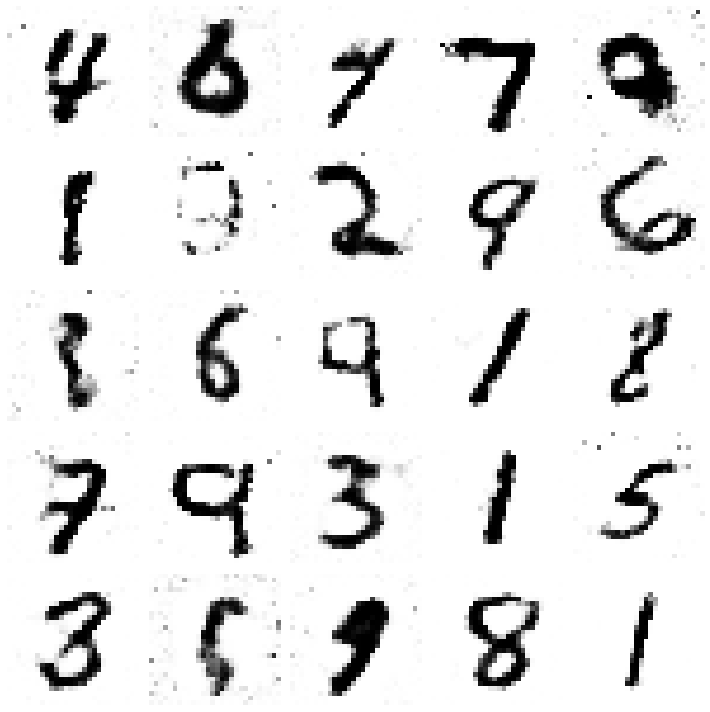

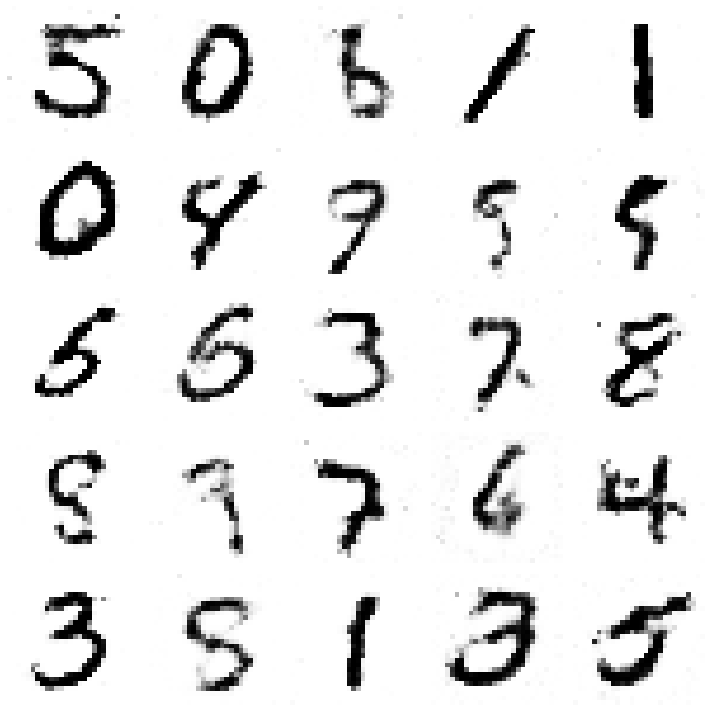

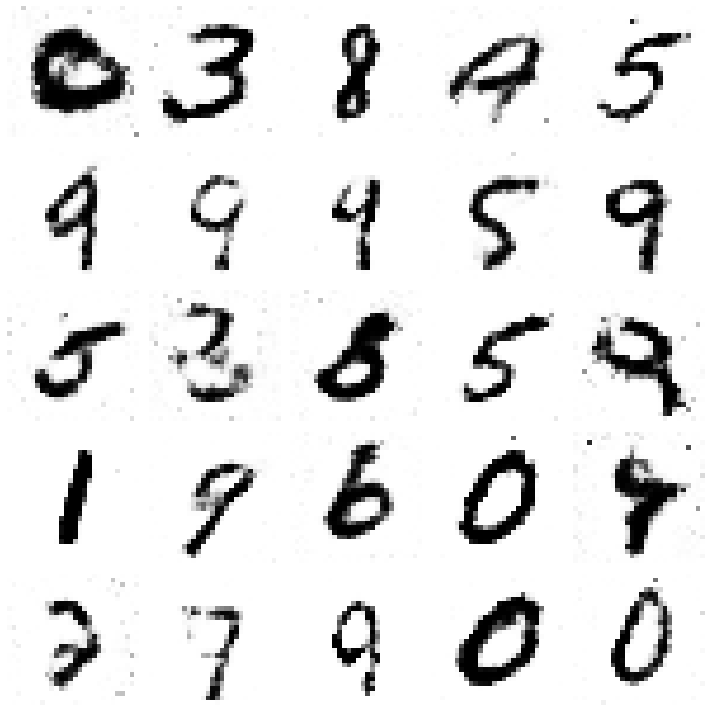

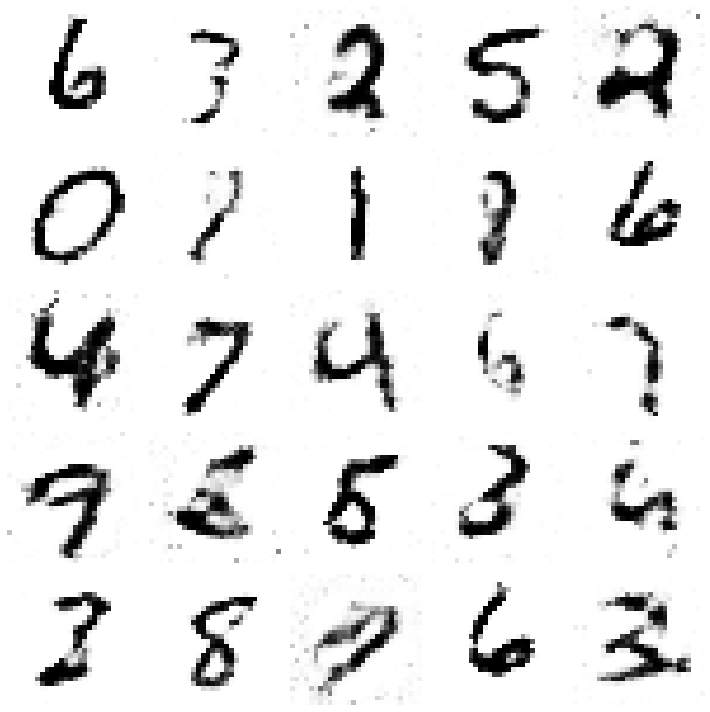

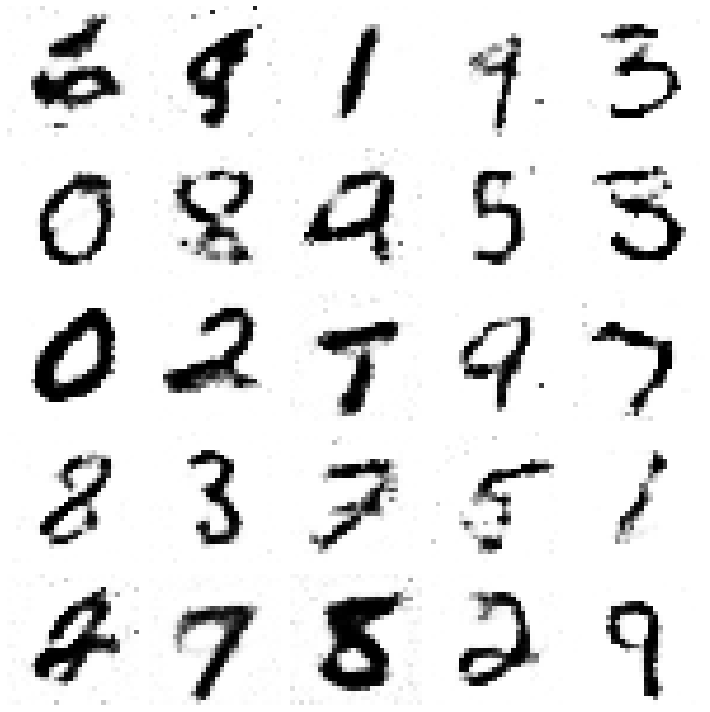

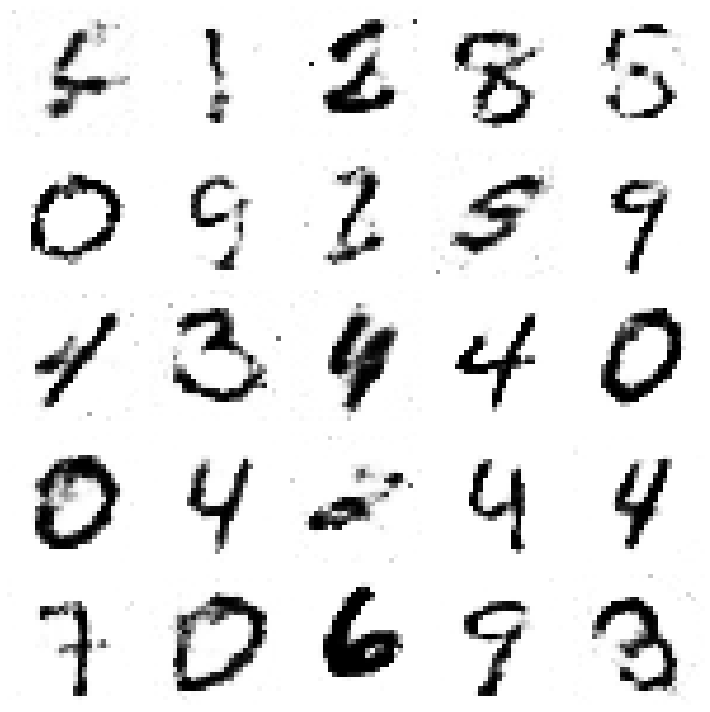

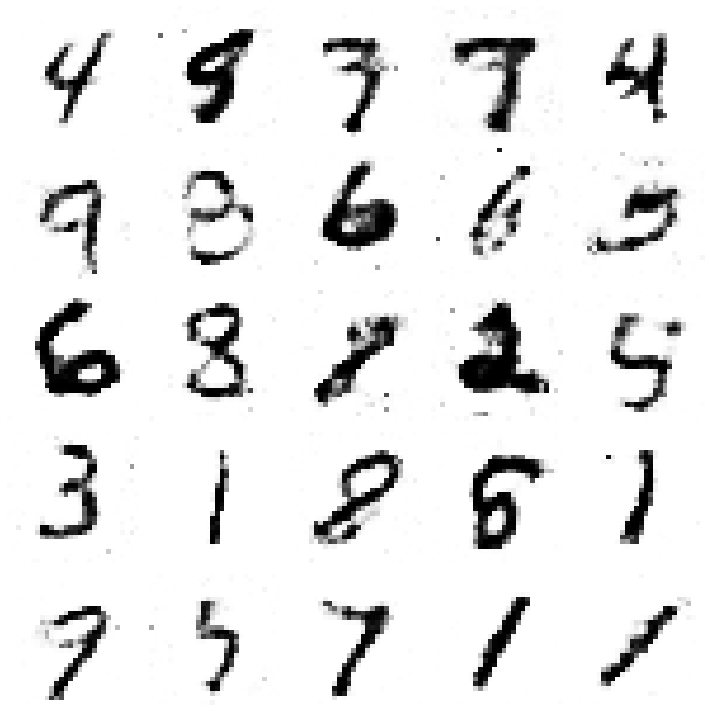

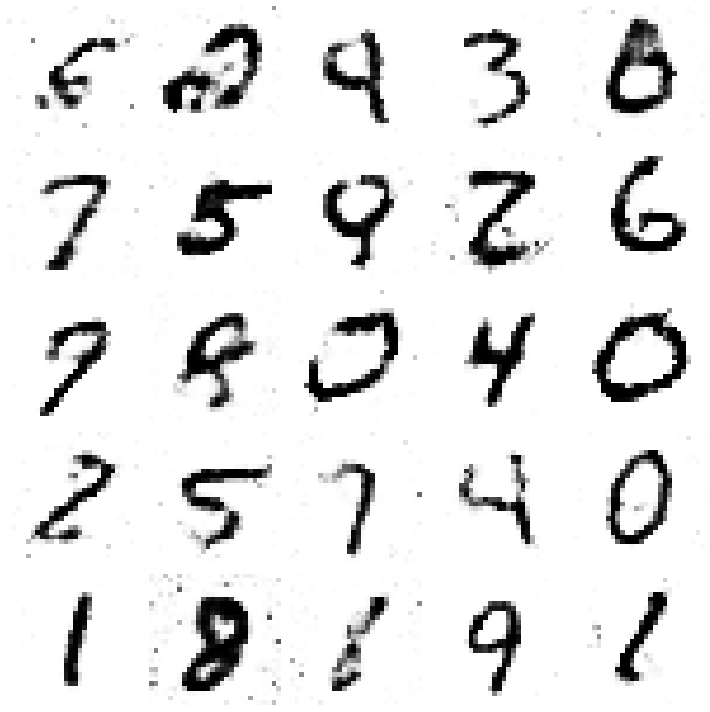

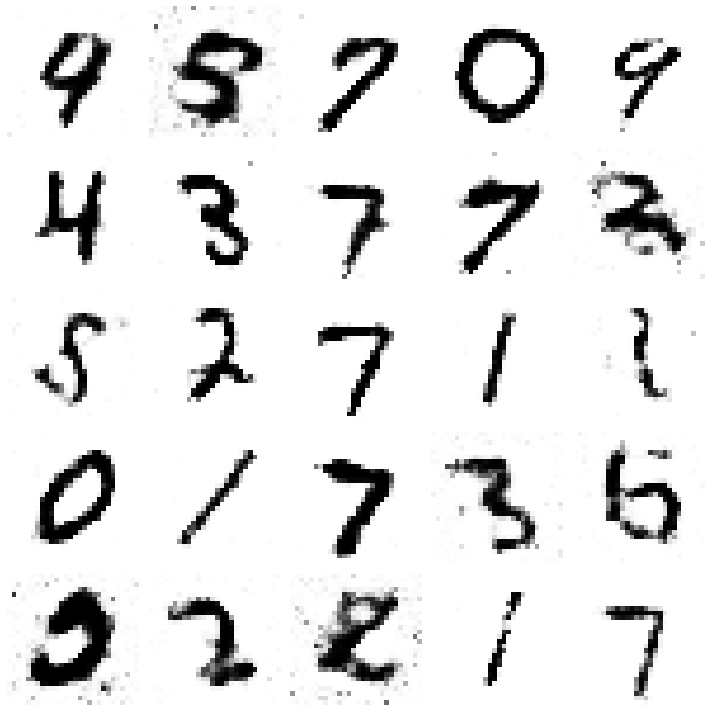

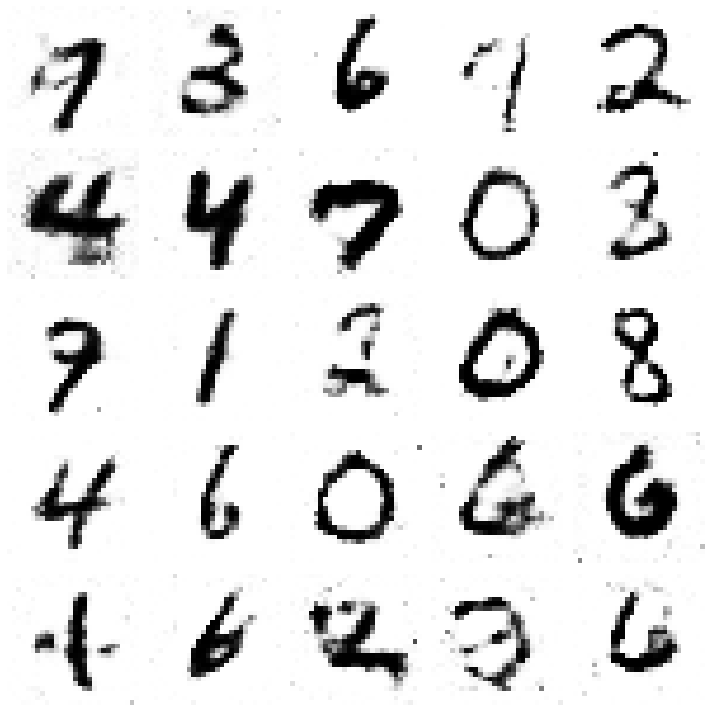

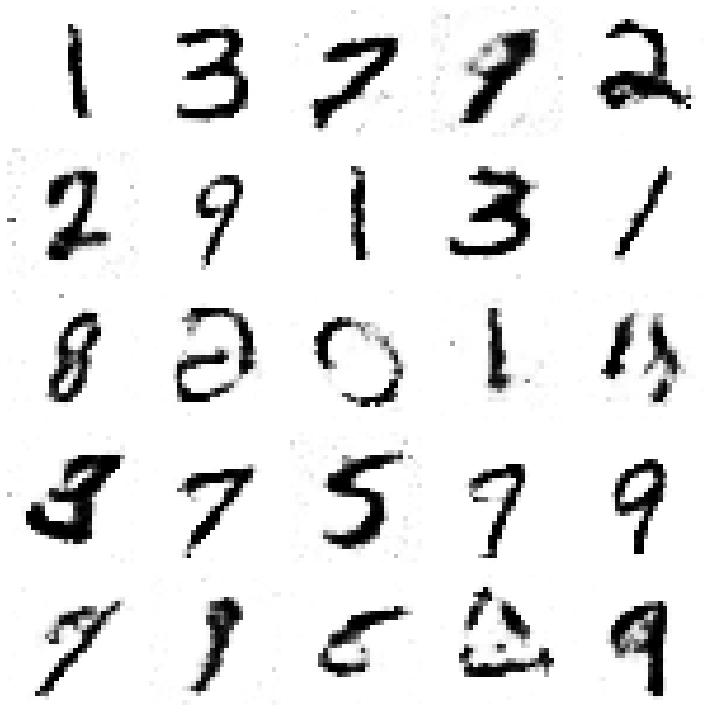

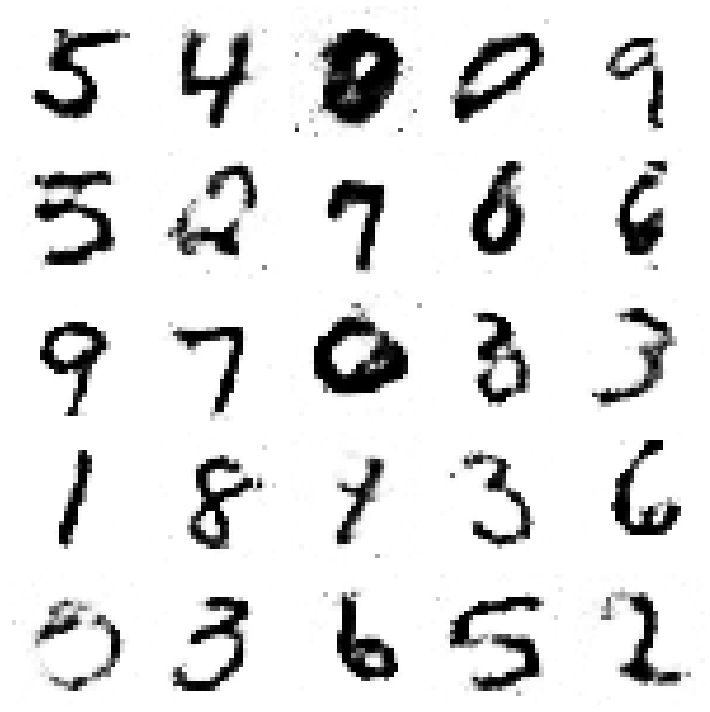

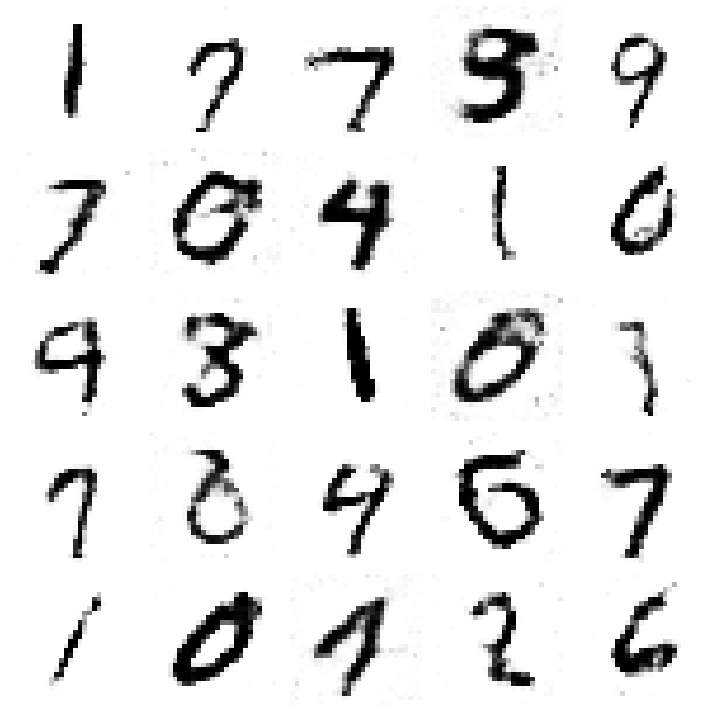

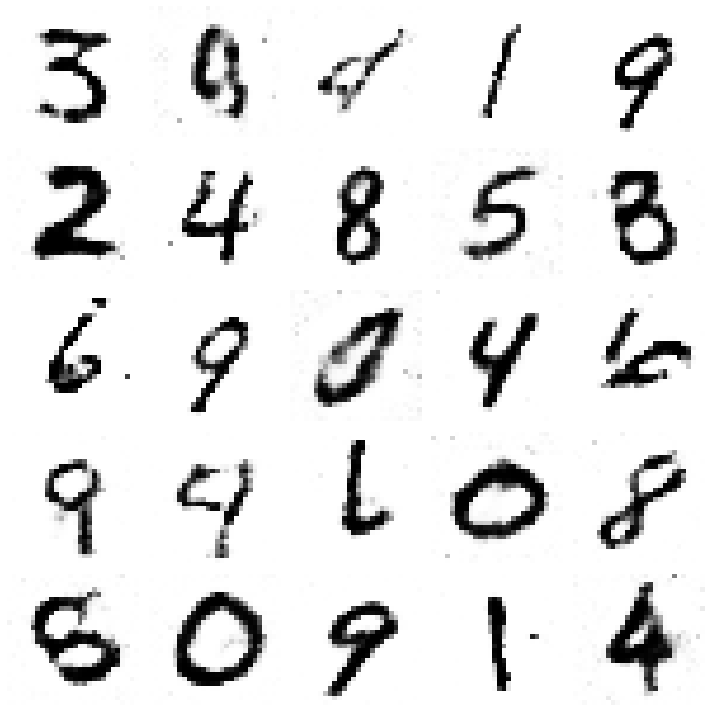

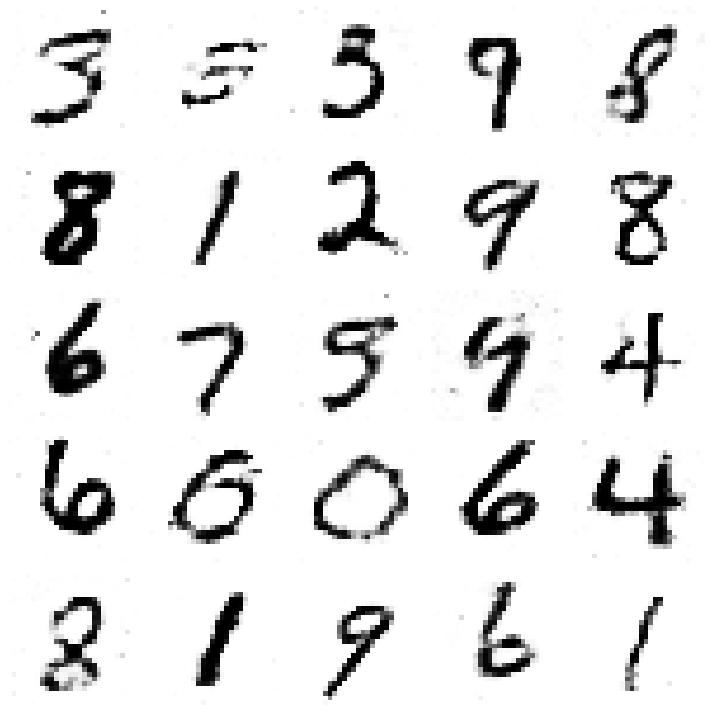

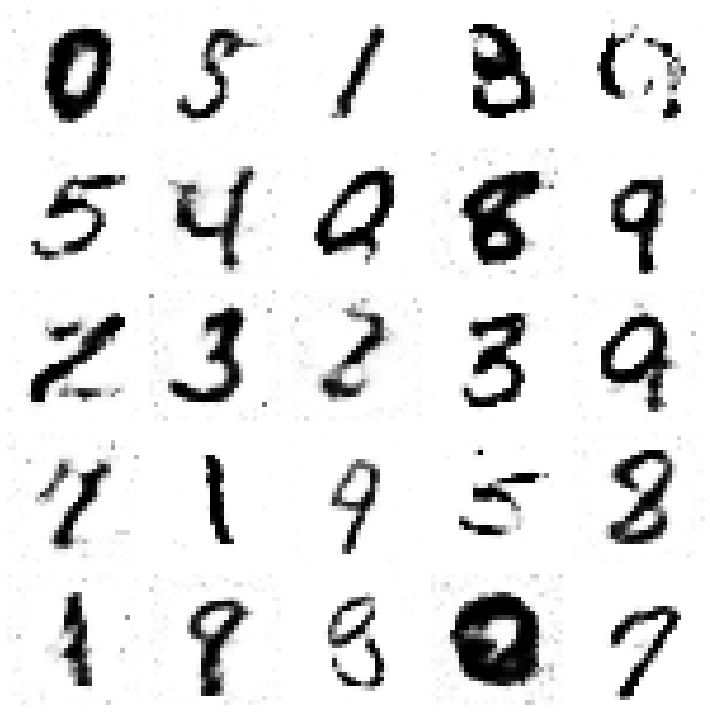

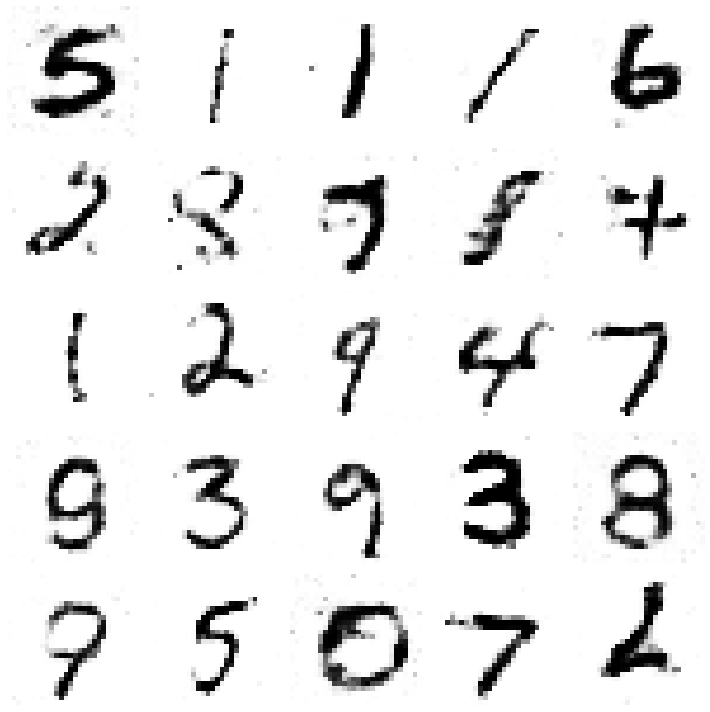

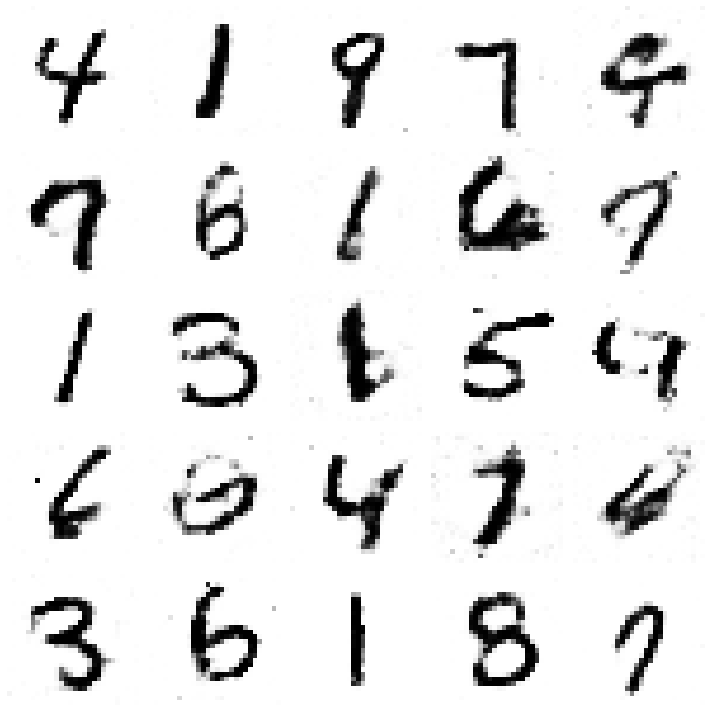

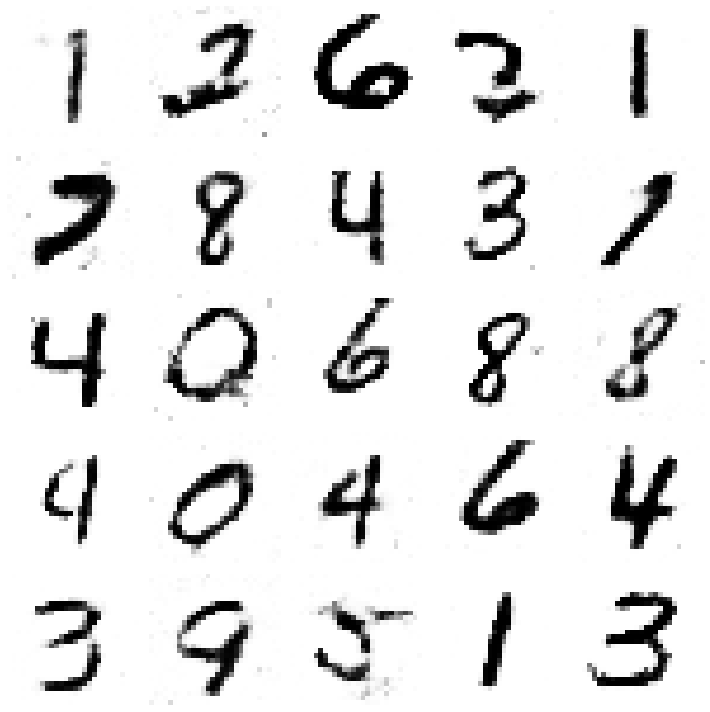

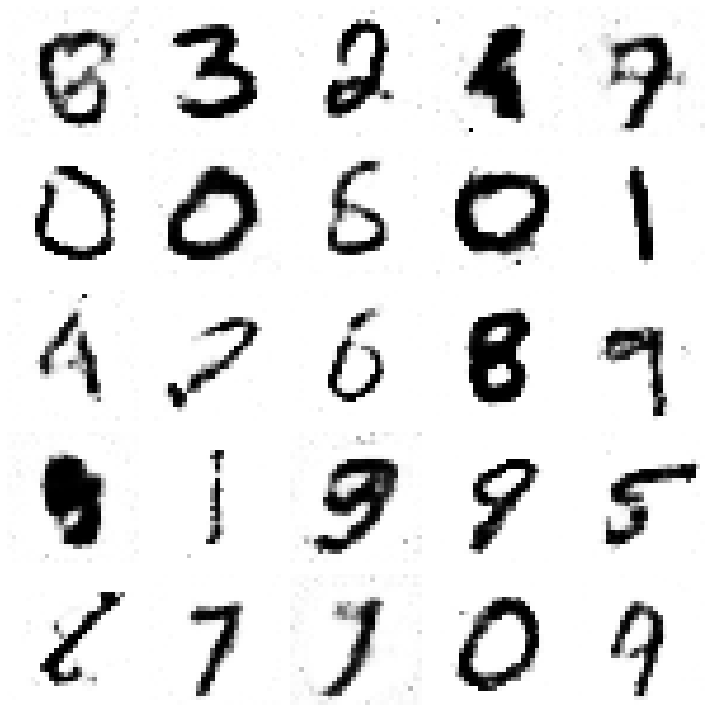

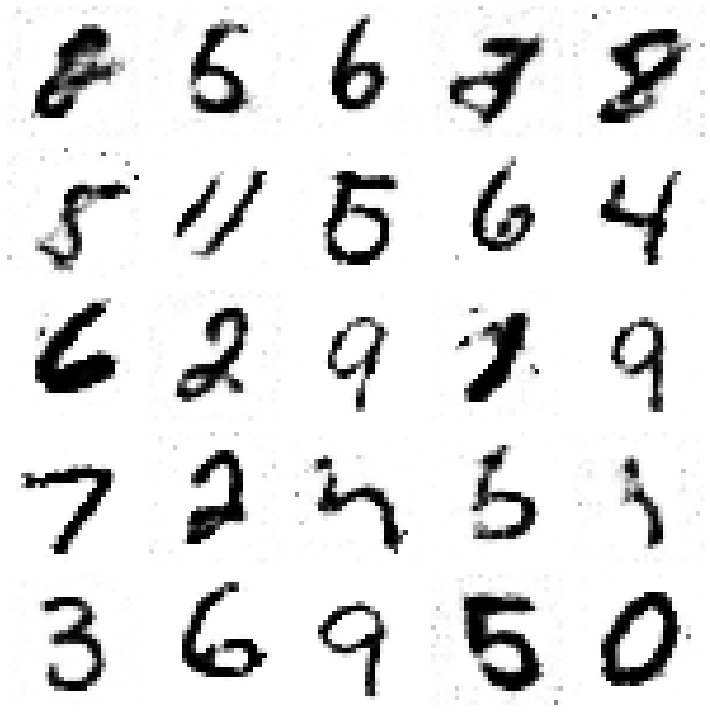

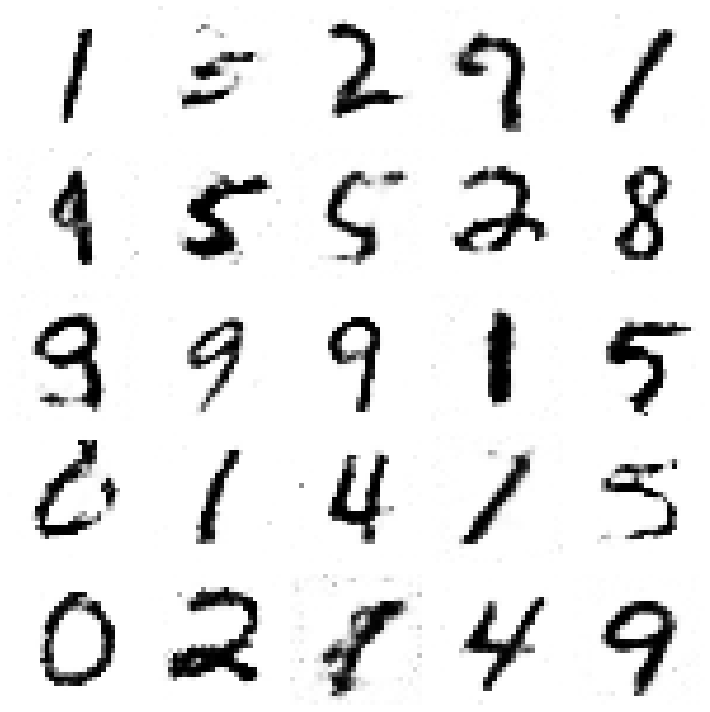

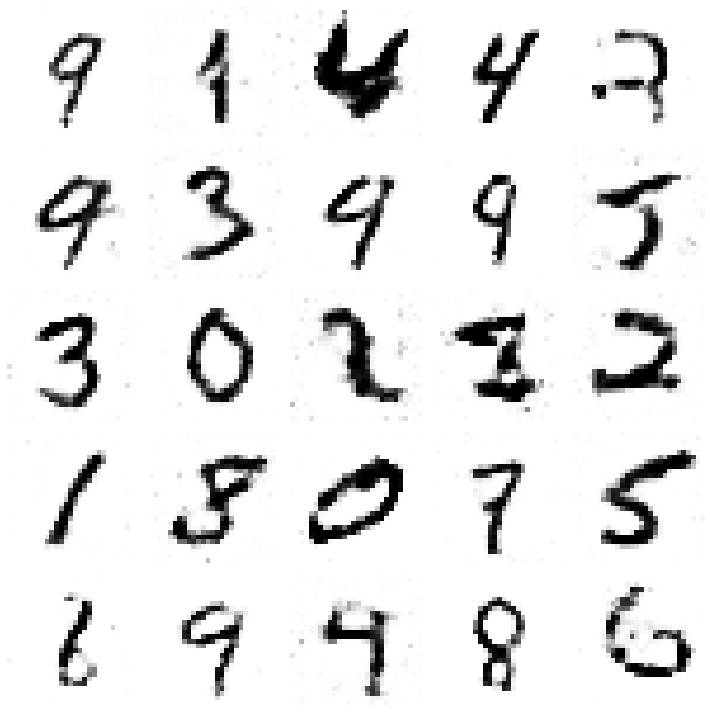

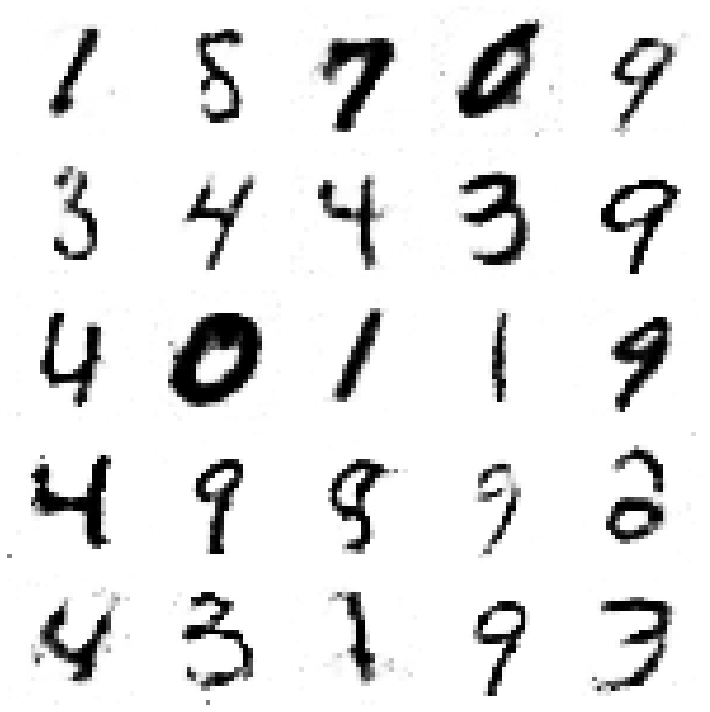

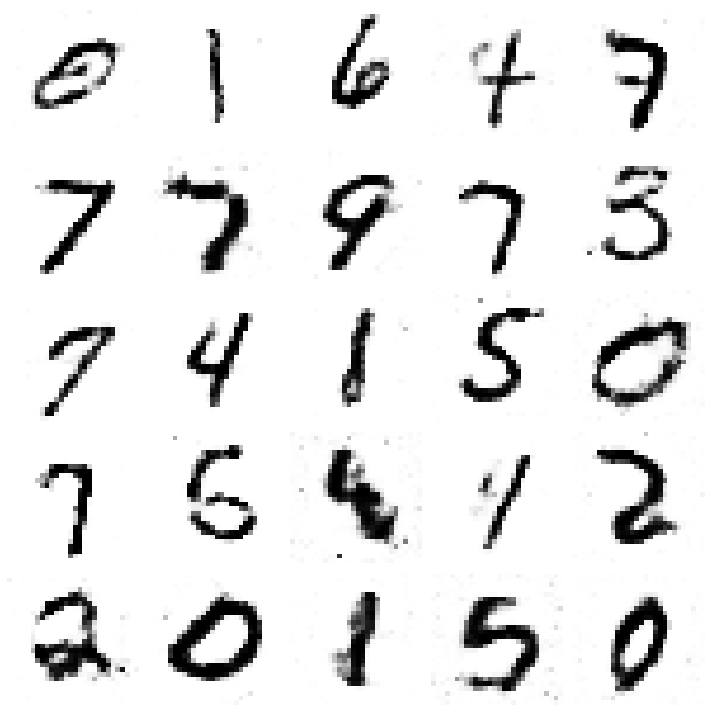

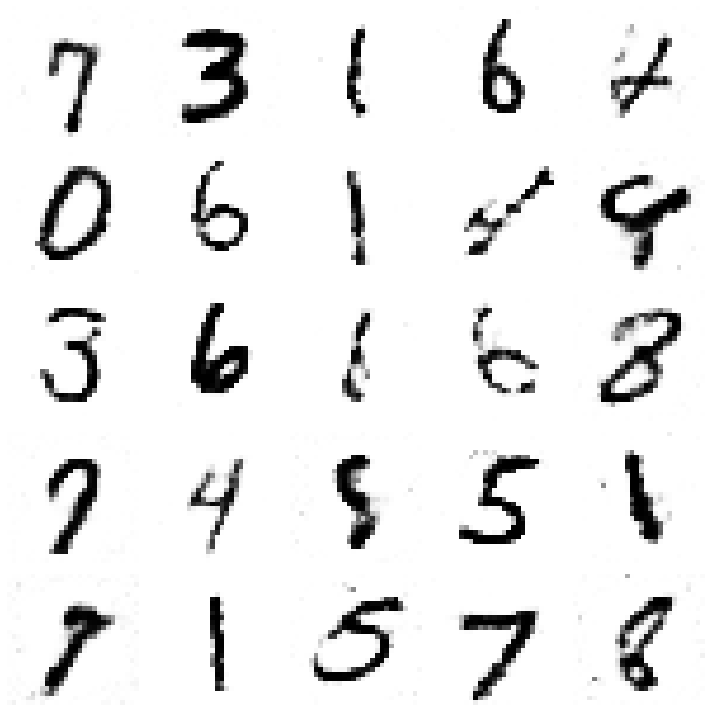

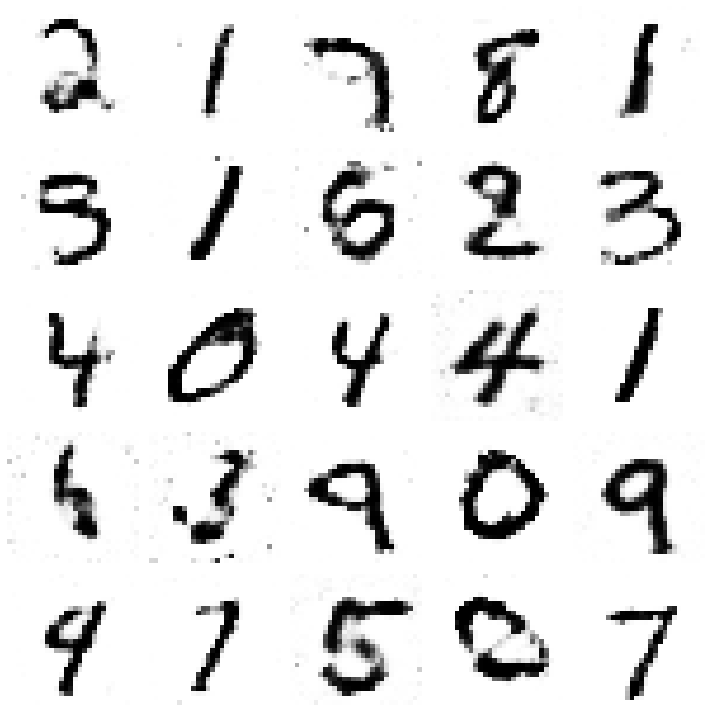

In [7]:
def train_GAN(epochs=1, batch_size=128):
    #Loading the data
    X_train, y_train = load_data()

    # Creating GAN
    generator= build_generator()
    discriminator= build_discriminator()
    GAN = build_GAN(discriminator, generator)

    for i in range(1, epochs+1):
        print("Epoch %d" %i)
    
        for _ in tqdm(range(batch_size)):
            # Generate fake images from random noiset
            # 我们生成呈高斯分布的噪声，利用generator，
            # 来生成batch_size（128张）图片。每张图片的输入就是一个1*100的噪声矩阵。
            noise= np.random.normal(0,1, (batch_size, 100))
            fake_images = generator.predict(noise)

            # Select a random batch of real images from MNIST
            # 同样的，我们从Mnist数据集中随机挑选batch_size张真实图片。
            # 我们给真实图片标注1，给假图片标注0，然后将2*batch_size张真假图片混合在一起。
            real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

            # Labels for fake and real images           
            label_fake = np.zeros(batch_size)
            label_real = np.ones(batch_size) 
            # Concatenate fake and real images 
            X = np.concatenate([fake_images, real_images])
            y = np.concatenate([label_fake, label_real])

            # Train the discriminator
            # 此时，我们利用上文提到的2*batch_size张带标签的真假图片，
            # 训练discriminator。训练完毕后，discriminator的weights得到了更新。
            discriminator.trainable=True
            discriminator.train_on_batch(X, y)

            # Train the generator/chained GAN model (with frozen weights in discriminator) 
            # 然后，我们冻结住discriminator的weights，让discriminator不再变化。
            discriminator.trainable=False
            # 然后就开始训练generator (chained GAN)。
            # 在GAN的训练中，我们输入一堆噪声，期待的输出是将假图片预测为真。
            # 在这个过程中，generator继续生成假图片，送到discriminator检验，
            # 得到检验结果，如果被鉴定为假，就不断更新自己的权重（假钞贩子不断改良造假技术），
            # 直到discriminator将加图片鉴定为真图片（直到当前鉴定假钞的技术无法识别出假钞）。
            GAN.train_on_batch(noise, label_real)

        # Draw generated images every 10 epoches     
        if i == 1 or i % 10 == 0:
            draw_images(generator, i)
        
train_GAN(epochs=400, batch_size=128)

现在，我们总结一下每次迭代发生了什么：

- Generator利用自己最新的权重，生成了一堆假图片。
- Discrminator根据真假图片的真实label，不断训练更新自己的权重，直到可以顺利鉴别真假图片。
- 此时discriminator权重被固定，不再发生变化。generator利用最新的discrimintor，苦苦思索，不断训练自己的权重，最终使discriminator将假图片鉴定为真图片。

换成印制假钞的例子，每次迭代发生了如下几件事：

- 假钞贩子根据最新造假技术，研发出一代假钞。
- 警察反复对比新型假钞和真币的区别，成功改良假钞鉴别方法，从而顺利鉴别出市面流通钞票的真伪。
- 假钞贩子生成假钞，马上被警察鉴别出来，痛定思痛，改良技术生成新的假钞。不成想，一上街又被警察识别了出来。日复一日，终于发明了新型假钞，当前的验钞技术已经无法成功检测出这种假钞。

然后通过每次迭代，discrimintor (警察的鉴定技术）和generator (假钞制作技术) 都越来越成熟...后来达到了动态平衡。

嗯，就这样，是不是挺简单的？

今天讲的是最原始的GAN网络，GAN发展到了如今已有许多变种，如将MLP结构换成CNN，Autoencoder，以及loss function的变化等等。我在github上找到一个超级全的用keras编写的各种花式GAN网络集合，有兴趣的小伙伴直接[点击这里](https://link.zhihu.com/?target=https%3A//github.com/eriklindernoren/Keras-GAN)。